In [25]:
import pickle
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import SugarscapeCg
from agents import Cop, Criminal
from scipy import stats
from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

## Helper functions

In [26]:
def run_model(model):
    model.run_model(step_count=300)

    output = model.datacollector.get_model_vars_dataframe()
    #print(output)

    return output

In [27]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [28]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [29]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    confidence_bounds = dict()
    means_dict_for_ci = {}
    
    for i in range(len(outputs)):
        for district in district_names:
            district_mean = np.mean(outputs[i].iloc[burn_in:][district])
            avg_crimes_per_distr_dict[district] += district_mean
            if district in means_dict_for_ci.keys():
                means_dict_for_ci[district].append(district_mean)
            else:
                means_dict_for_ci[district] = [district_mean]
          
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    avg_crimes_per_distr_dict = dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))
    
    
    for district in avg_crimes_per_distr_dict.keys():
        confidence_bounds[district] = 1.96*np.std(means_dict_for_ci[district])/len(means_dict_for_ci[district])
    return avg_crimes_per_distr_dict, confidence_bounds

In [30]:
def zipf(height):
    """
    Returns y values following zipf's law given a starting height and x values between 0 and 6.
    """
    x = np.linspace(1, 7, 1000)
    y = height / x
    y = np.flip(y)
    x = np.linspace(0, 6, 1000)
    return x, y


def ks_test(avg_crimes_per_district_dict, visual=False):
    """
    Returns a Kolmogorov-Smirnov test between the average number of crimes in each distract and zipf's law.
    """

    # average crimes placed in list
    avg_per_district = list(avg_crimes_per_district_dict.values())
    x_avg = np.linspace(0, 1, len(avg_per_district))

    # values follwoing zipf law with same max
    zipf_list = zipf(max(avg_per_district))[1]
    x_zipf = np.linspace(0, 1, len(zipf_list))

    # visual comparison of cdf's
    if visual:
        plt.plot(x_avg, np.cumsum(avg_per_district) / sum(avg_per_district), label='districts')
        plt.plot(x_zipf, np.cumsum(zipf_list) / sum(zipf_list), label='zipf')
        plt.legend()
        plt.show()

    # statistical test, if p-value is low, reject null-hypothesis that they are identical
    test = stats.kstest(avg_per_district, zipf_list) 
    return test

## Plotting functions

In [31]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [32]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [33]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [34]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors,confidence_bounds,filename):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), yerr=confidence_bounds.values(), color=district_colors, capsize=10)
    ct = datetime.datetime.now().strftime('%d-%m-%Y %H %M %S')
    name = filename + ct + '.jpeg'
    plt.savefig(name,dpi='figure')
    plt.show()
    return

In [35]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1
max_steps = 300
distinct_samples = 500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)
# print(param_values)

# Round and cast param_values to integers
param_values_rounded = [np.rint(row).astype(int) for row in param_values]
# uniques = np.unique(param_values_rounded,axis=0)
# print(len(uniques))
param_values = param_values_rounded
# print(uniques)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (5) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [14]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

   jail_sentence criminal_risk_radius cop_catch_radius criminal_risk_aversion  \
0              2                    5                5                    328   
1             19                    5                5                    328   
2              2                    6                5                    328   
3              2                    5                9                    328   
4              2                    5                5                    234   
5              2                    5                5                    328   
6             19                    6                9                    234   
7             12                   10               10                     78   
8              9                   10               10                     78   
9             12                    1               10                     78   
10            12                   10                4                     78   
11            12            

In [ ]:
data_cp = data.copy()

# values_not_covered = []
# values = np.arange(500)
# criminal_risk_aversion = data_cp['criminal_risk_aversion'].values

# for value in values:
#     if value in criminal_risk_aversion:
#         print(value)
#         # values_not_covered.append(value)

# print(len(values_not_covered))
# print(values_not_covered)

while data_cp.shape[0] != 3500:
    data_cp = data_cp.append(pd.Series(0, index=data_cp.columns), ignore_index=True)

print(data_cp)

     jail_sentence criminal_risk_radius cop_catch_radius  \
0                0                    1                7   
1                0                    1                7   
2                0                    1                8   
3                0                    1                8   
4                0                    1                8   
...            ...                  ...              ...   
3495             0                    0                0   
3496             0                    0                0   
3497             0                    0                0   
3498             0                    0                0   
3499             0                    0                0   

     criminal_risk_aversion criminal_disconnectivity  Run   Centrum  \
0                       202                       21  0.0  6.144225   
1                       269                       66  1.0    6.6516   
2                       159                       30  2.0  6.51727

In [ ]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

Si_crimes


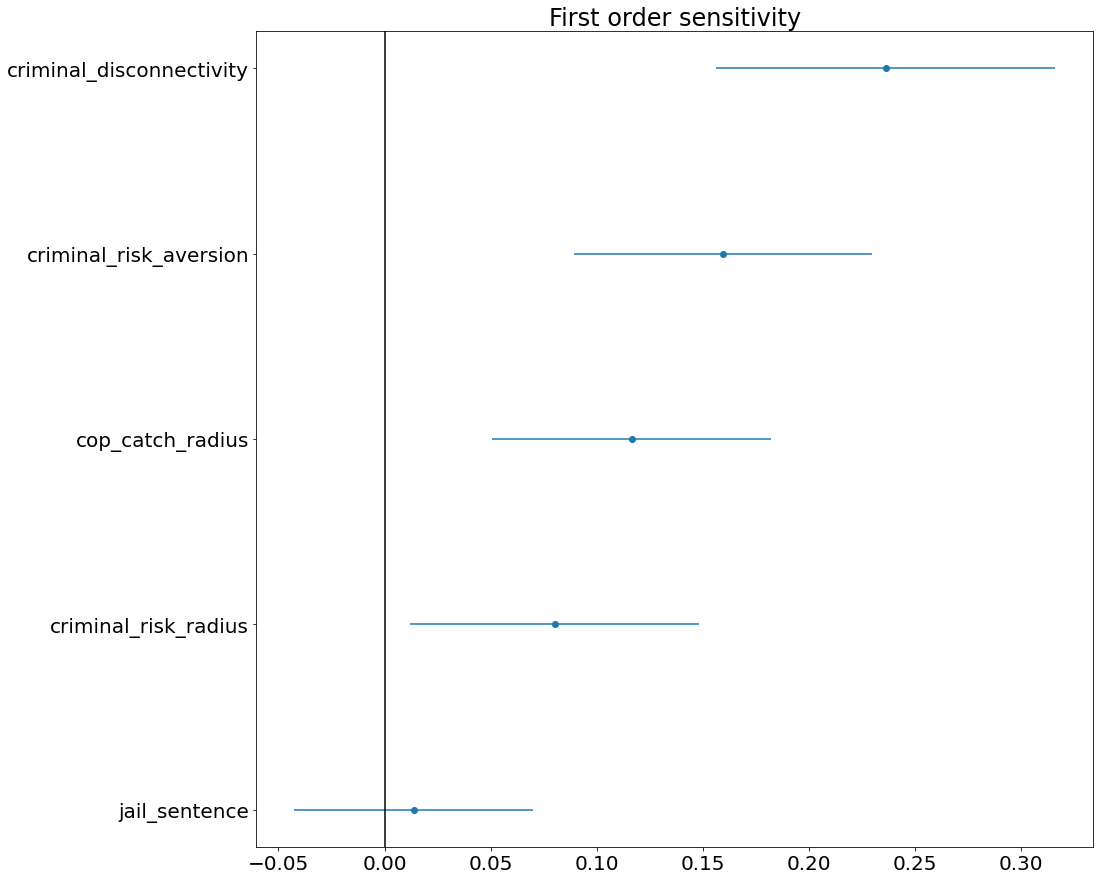

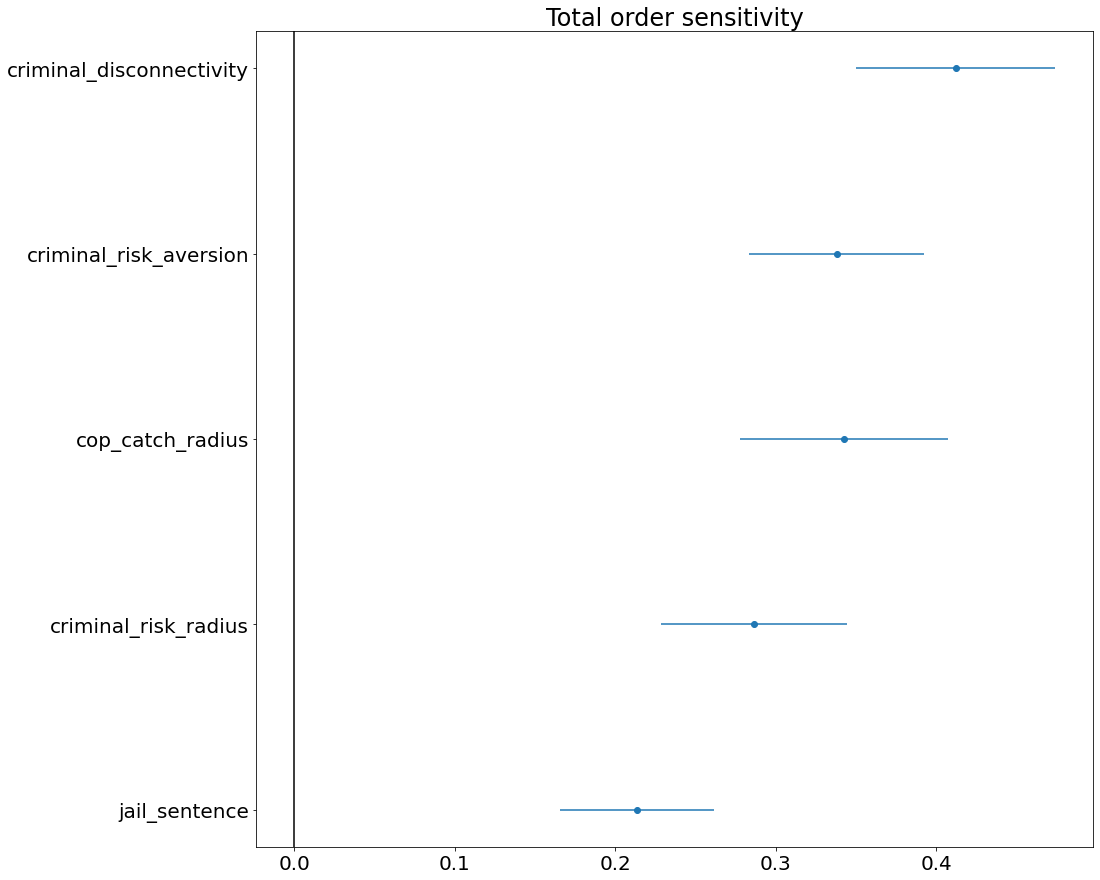

Si_jail


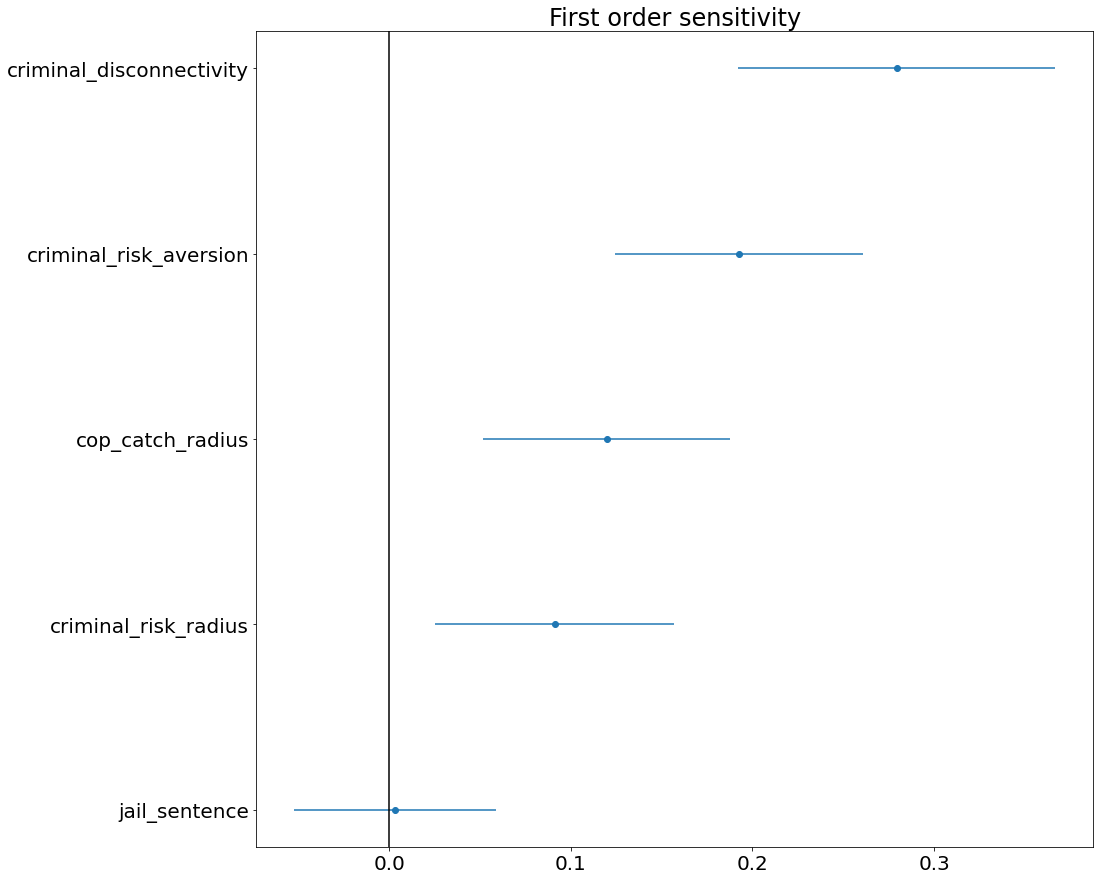

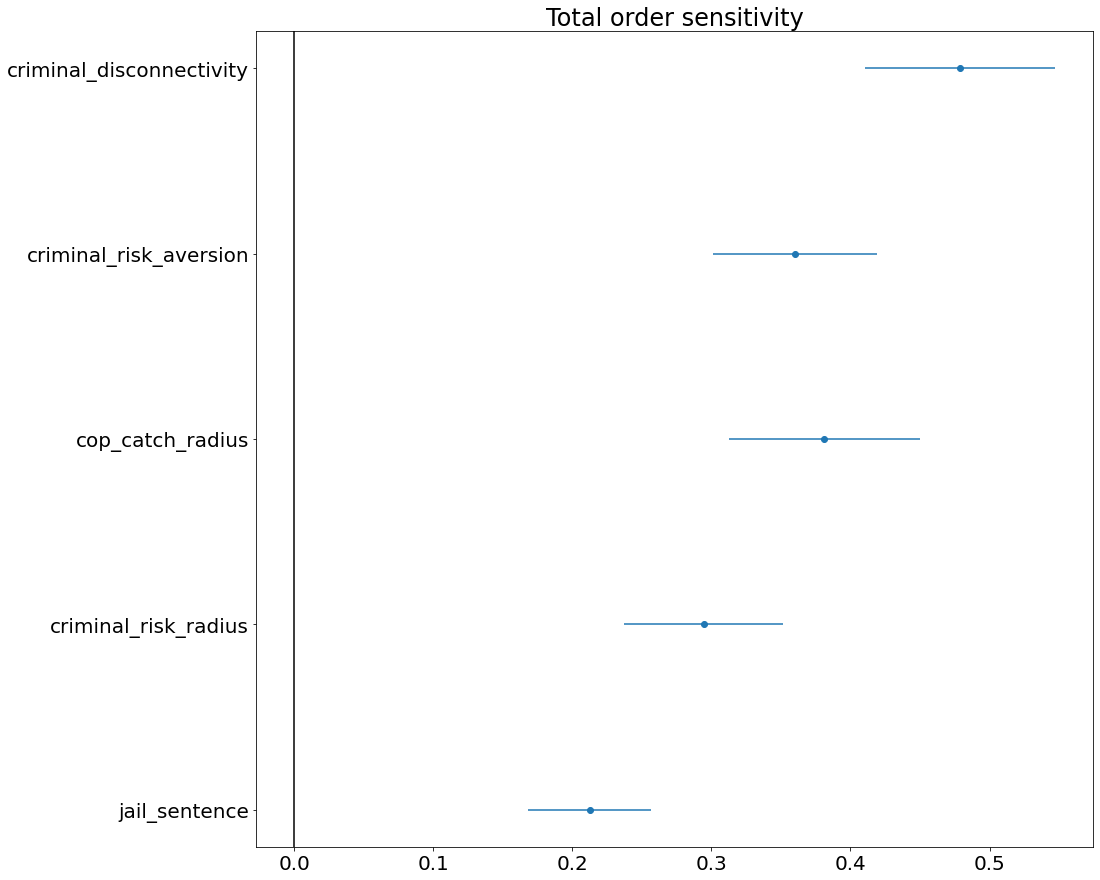

Si_centrum


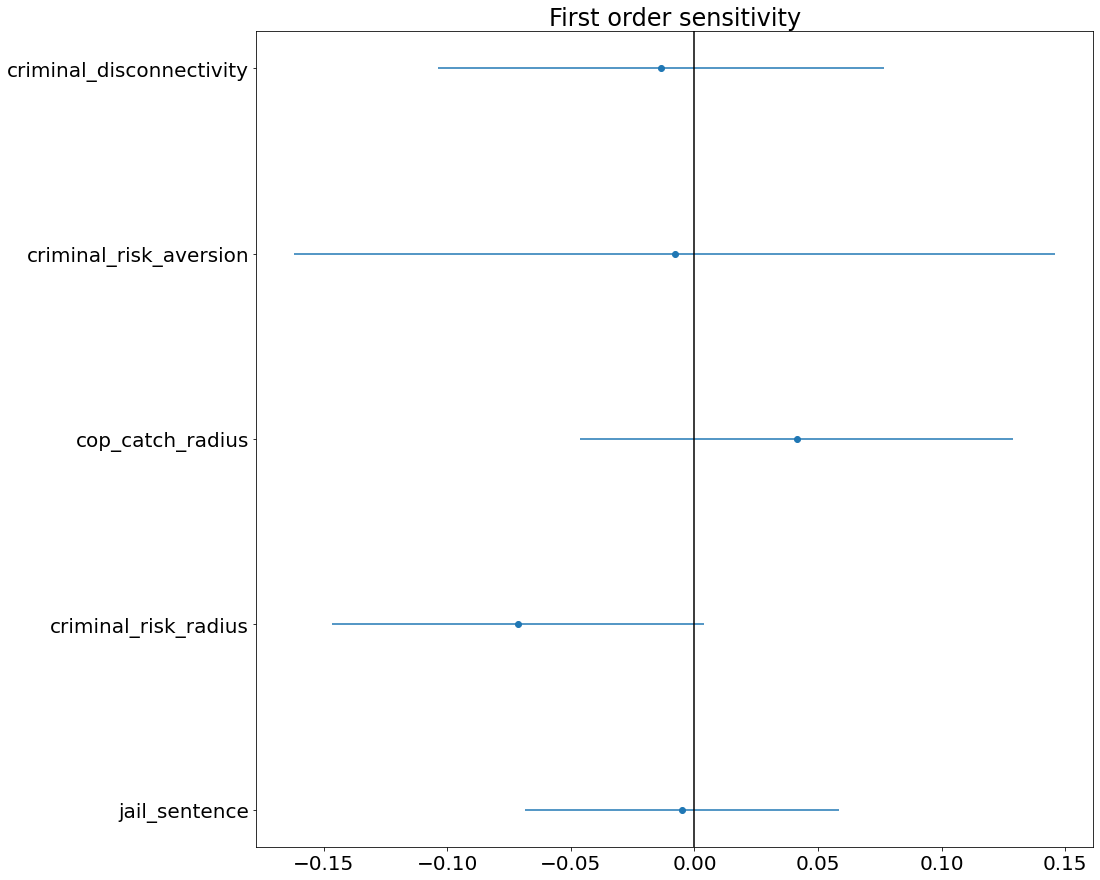

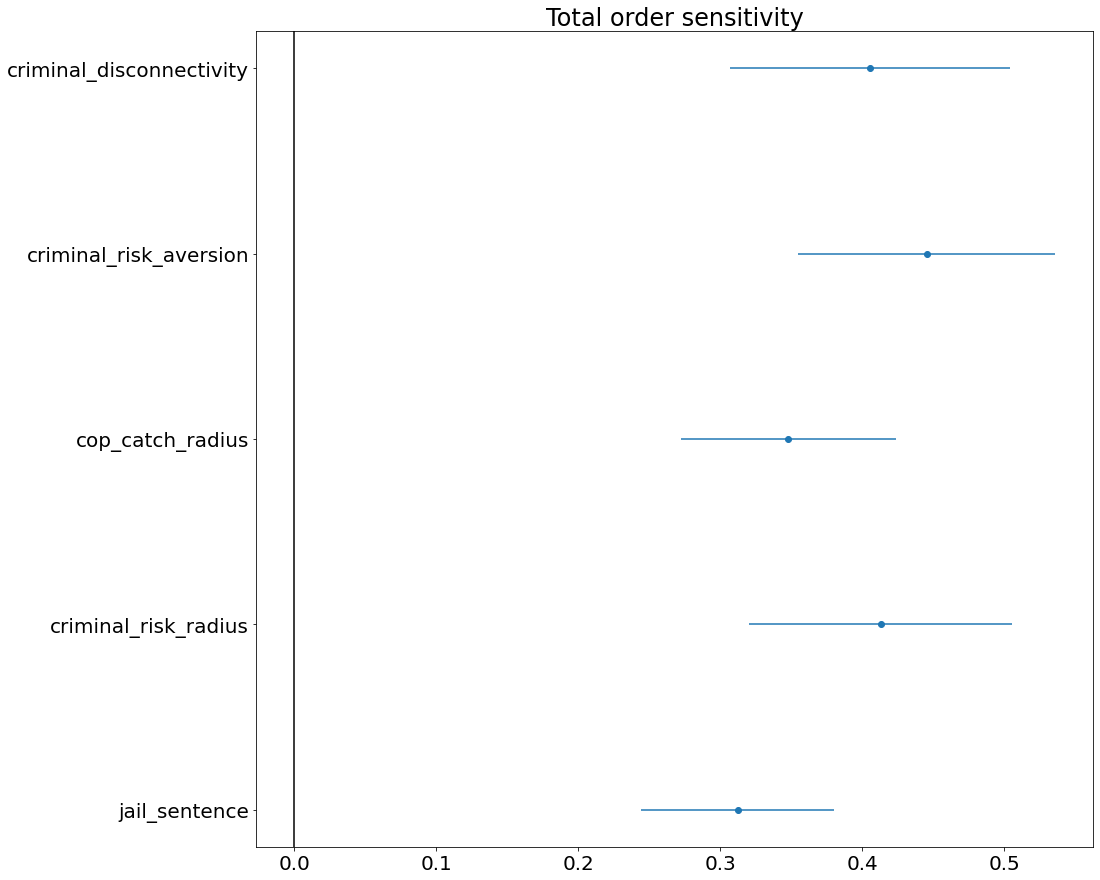

Si_noord


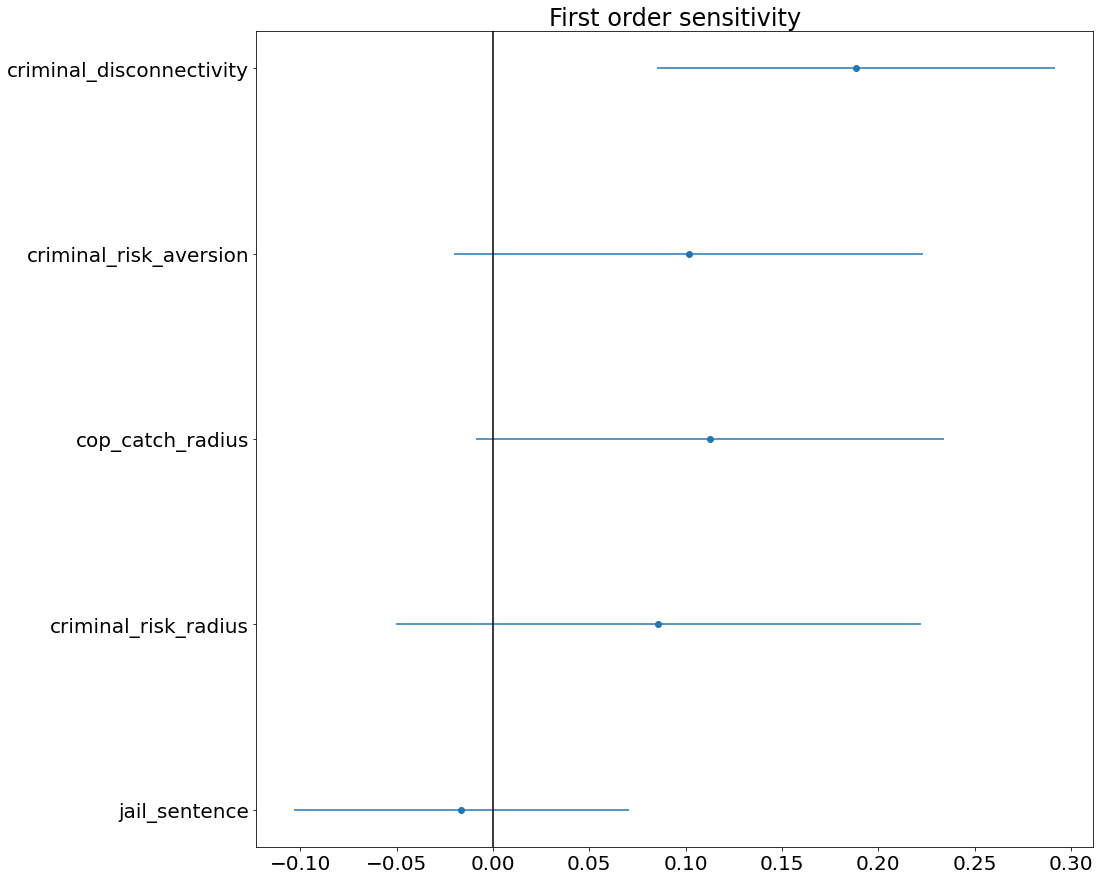

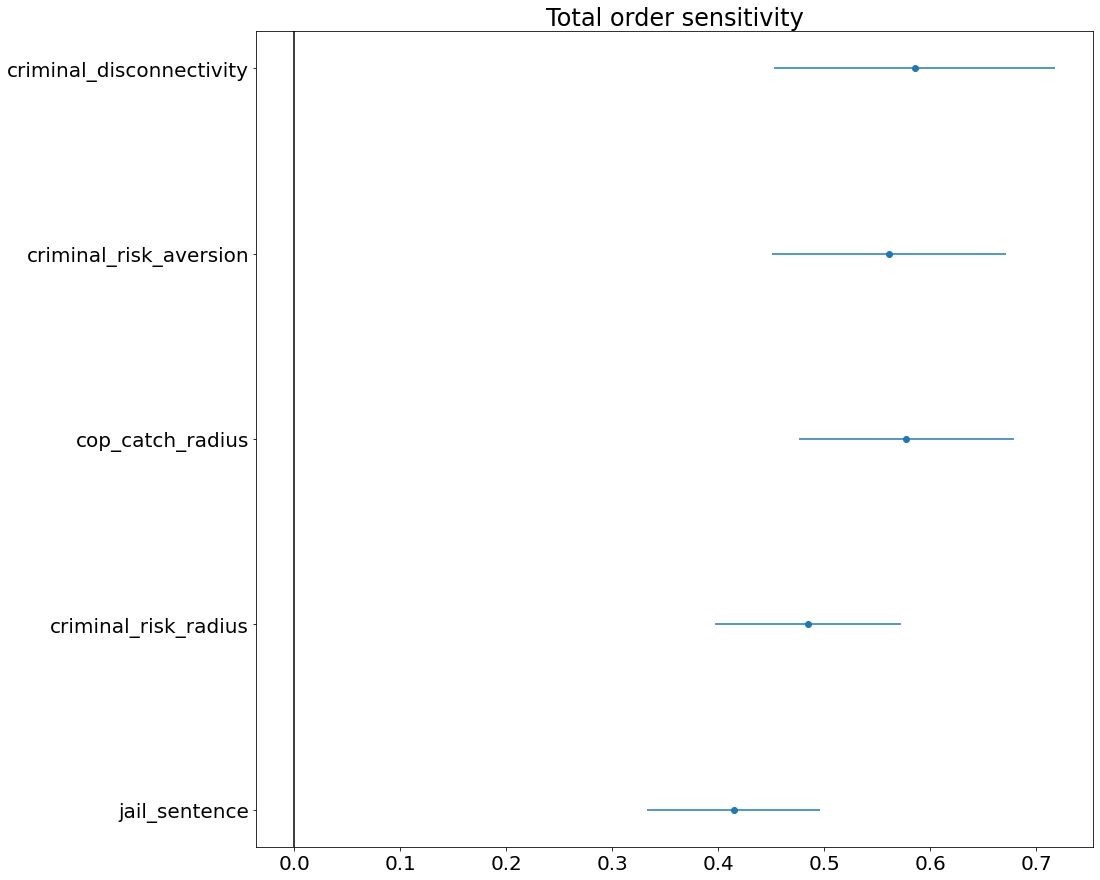

Si_west


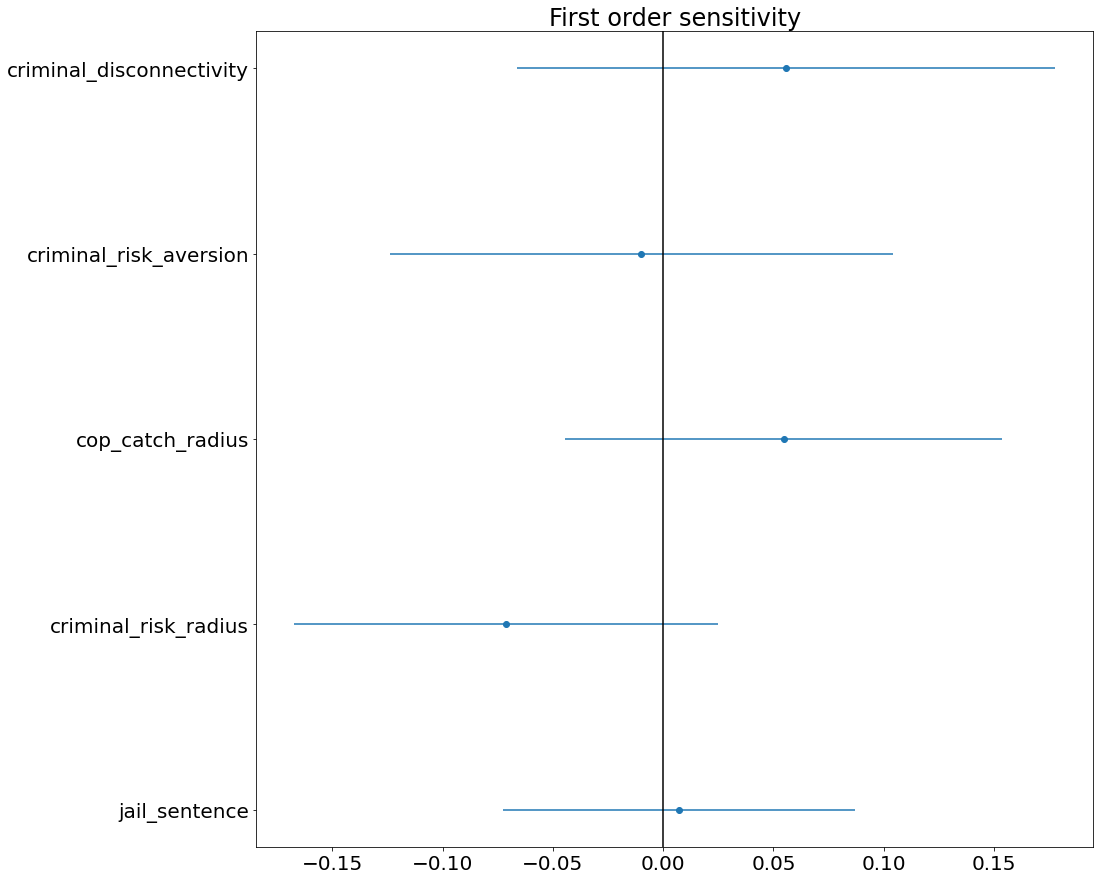

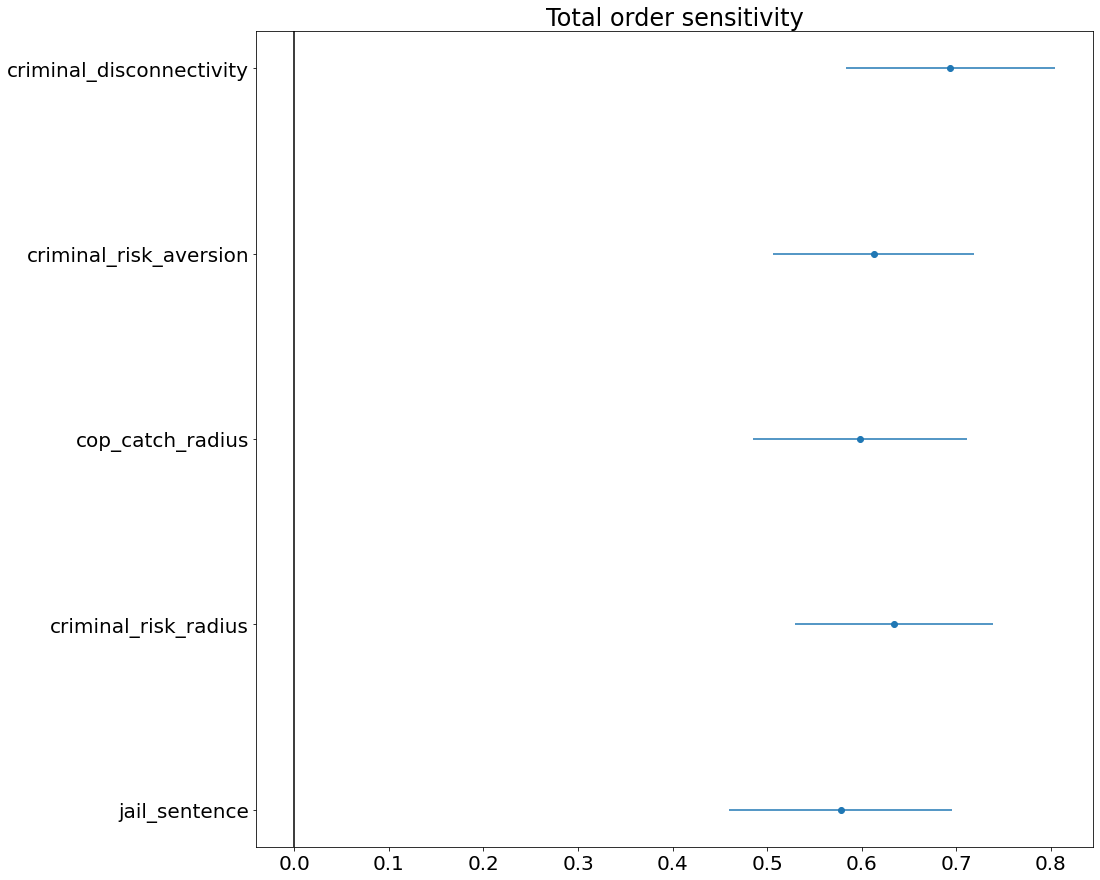

Si_zuid


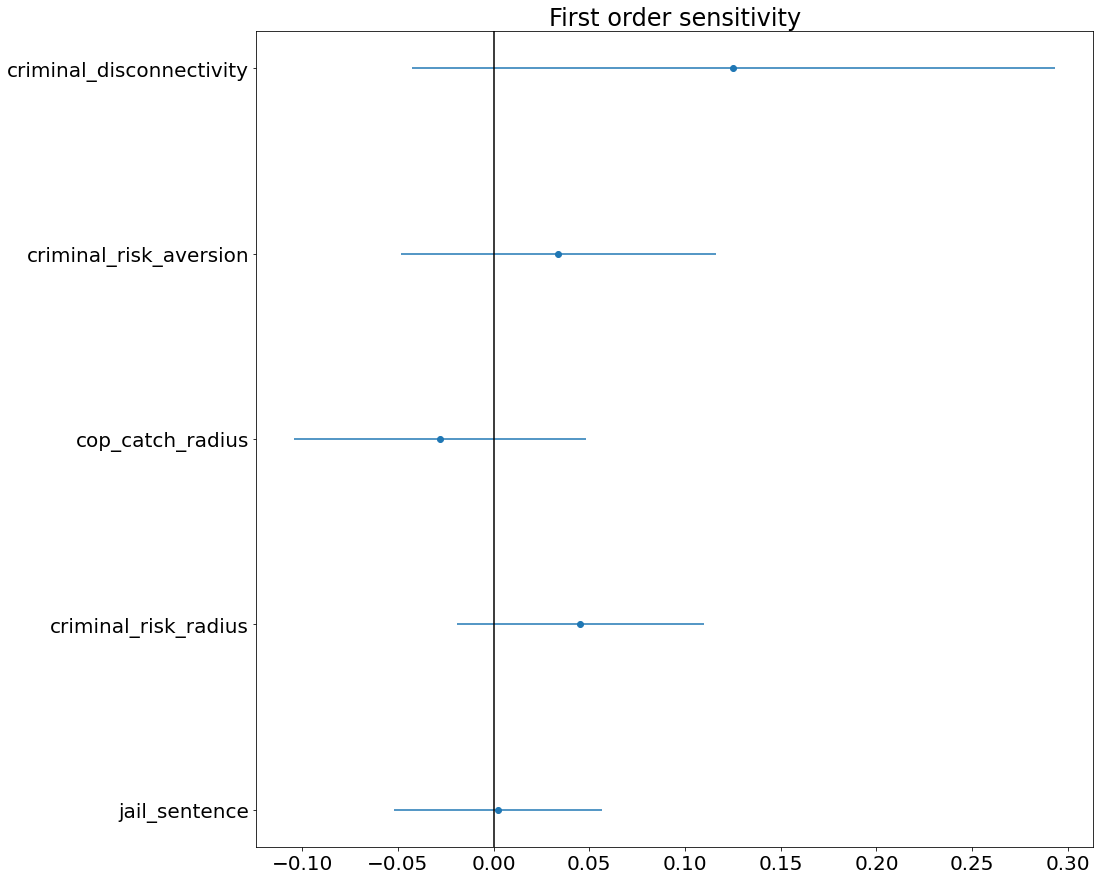

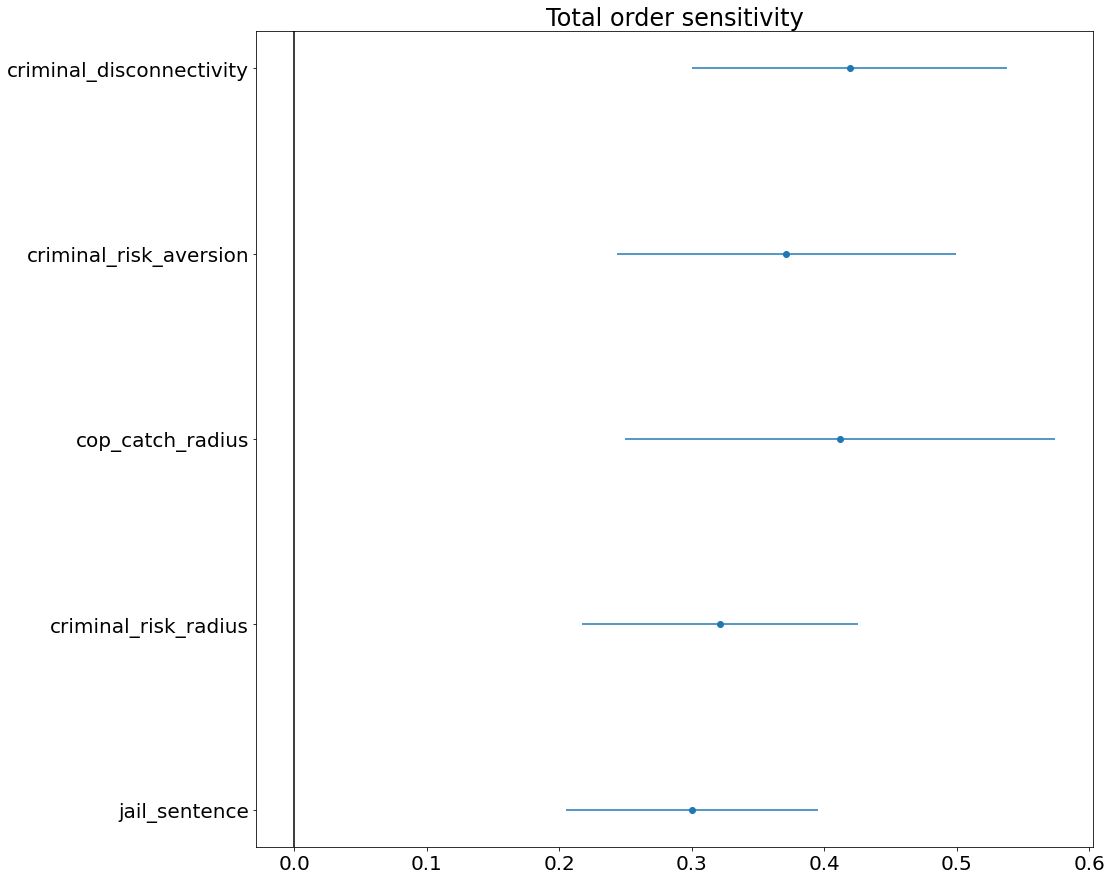

Si_zuidoost


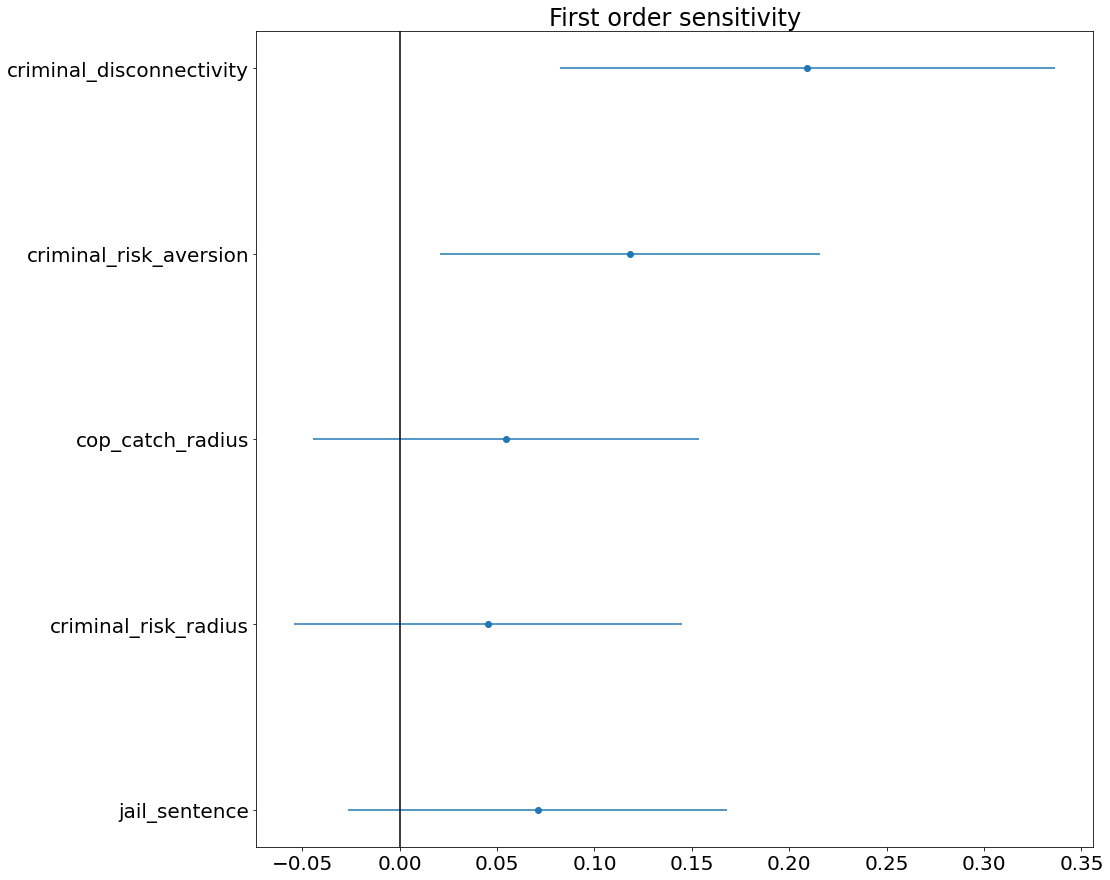

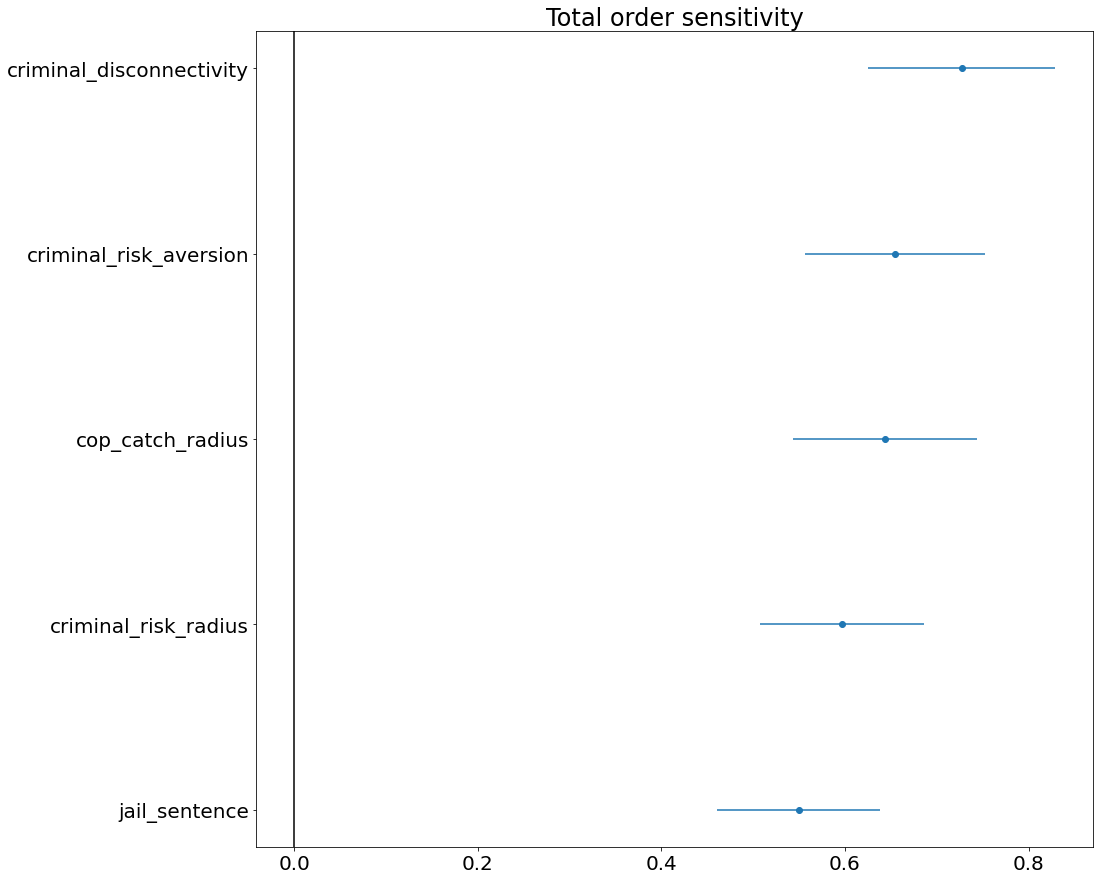

Si_oost


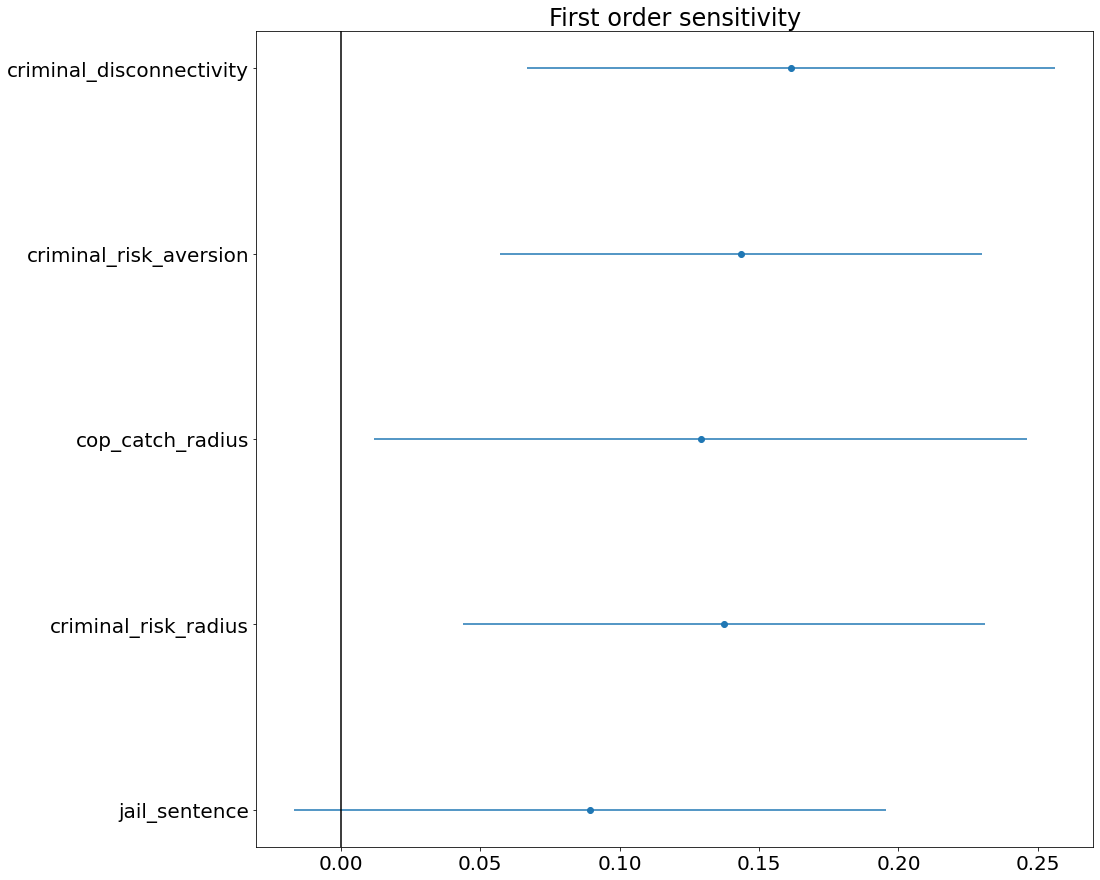

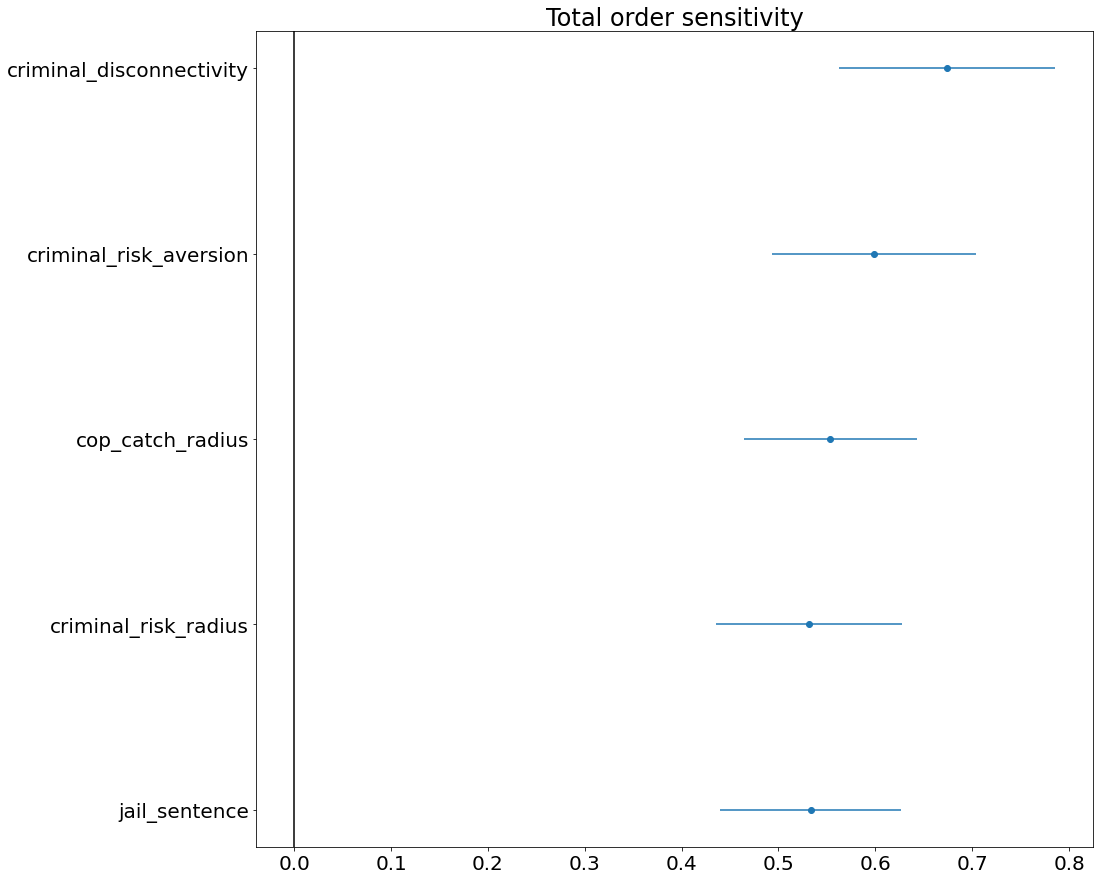

Si_nieuw_west


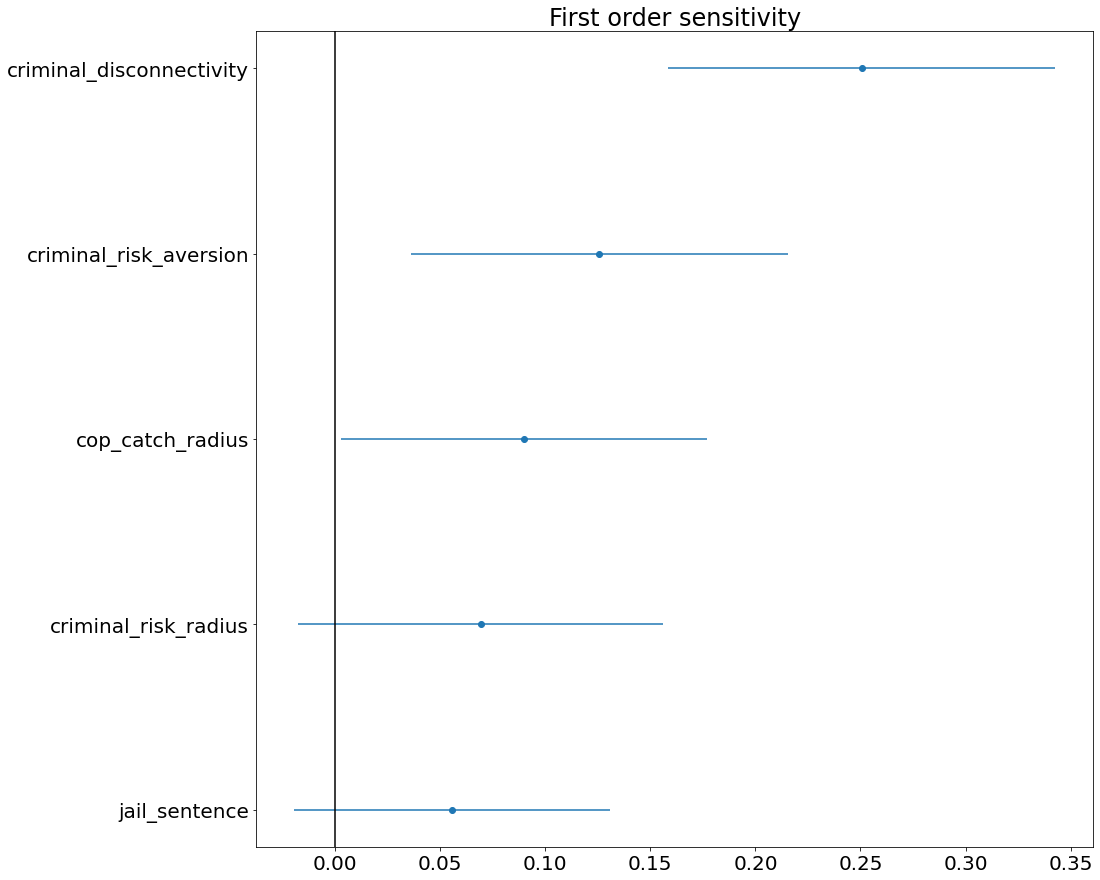

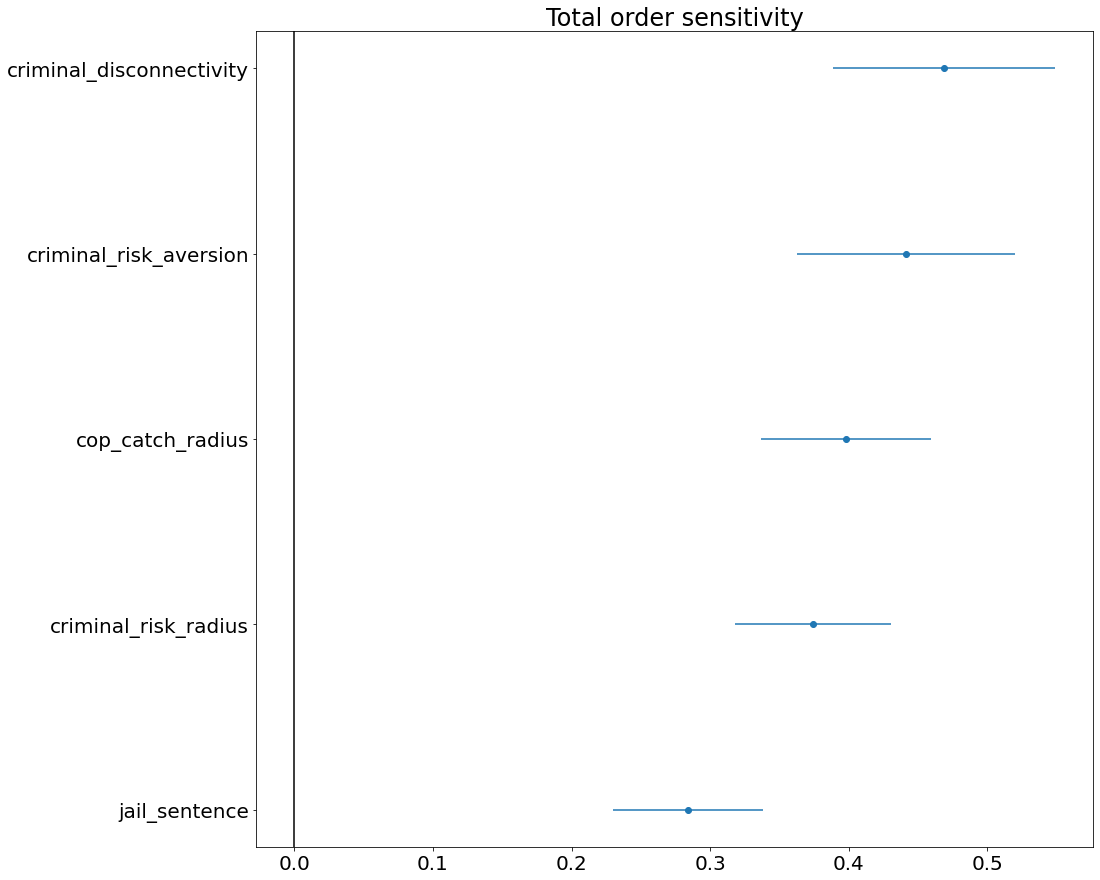

In [ ]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Experiments

## Criminal disconnectivity experiment

In [ ]:
num_runs = 50
outputs = []
output_dict = {}

criminal_disconnectivities = [0,25,75,100]

for val in criminal_disconnectivities:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_disconnectivity=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict:
            output_dict[val].append(output)
        else:
            output_dict[val] = [output]
        #outputs.append(output)

In [ ]:
with open('experiment_outputs/experiment_output_cd.pkl', 'wb') as f:
    pickle.dump(output_dict, f)

No handles with labels found to put in legend.


Criminal disconnectivity 0


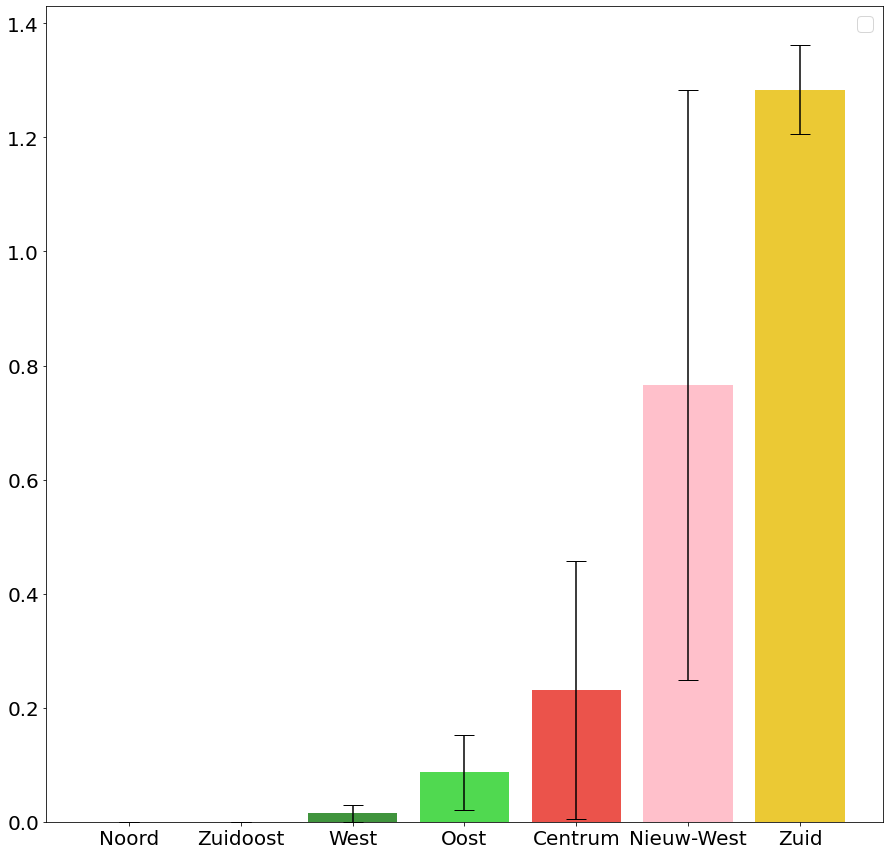

No handles with labels found to put in legend.


Criminal disconnectivity 15


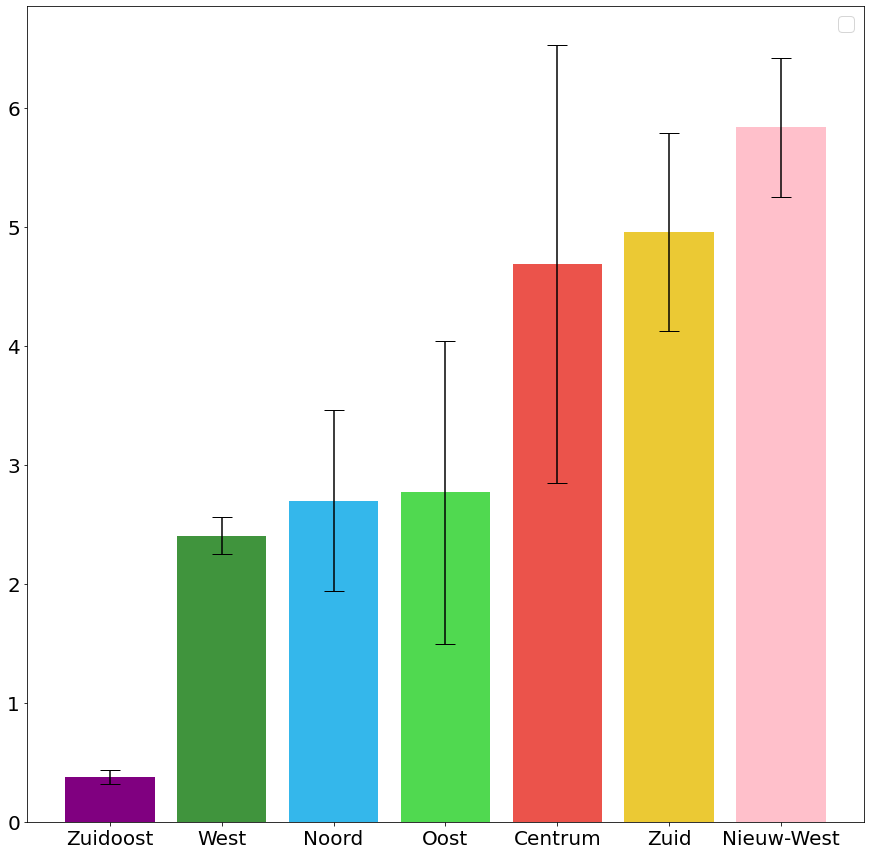

No handles with labels found to put in legend.


Criminal disconnectivity 30


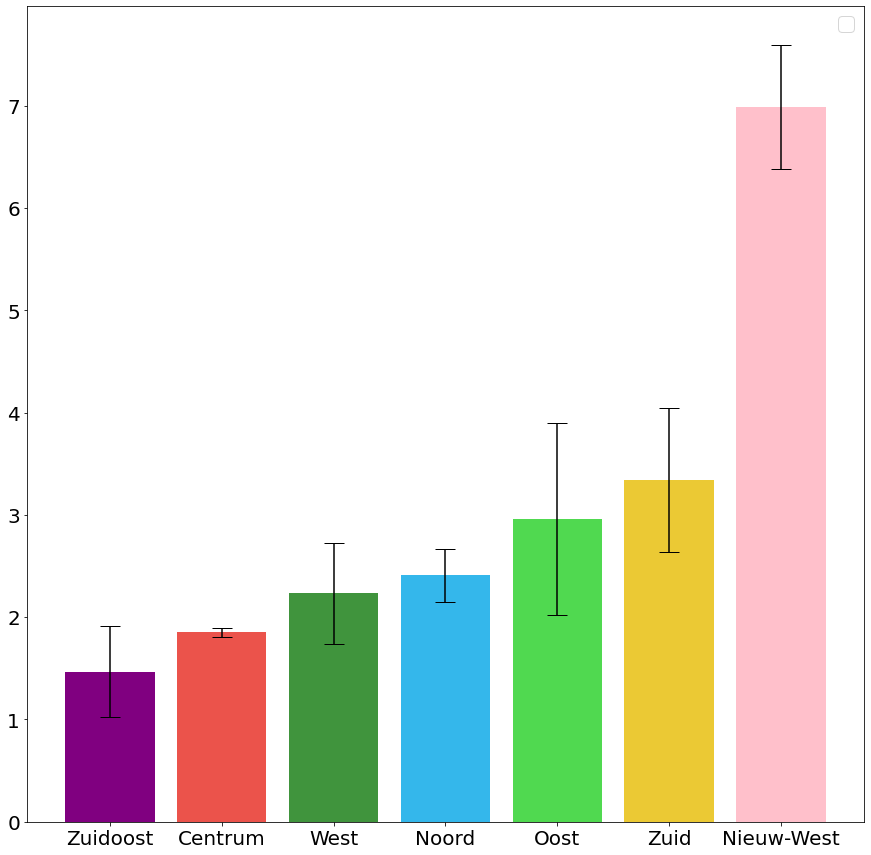

No handles with labels found to put in legend.


Criminal disconnectivity 45


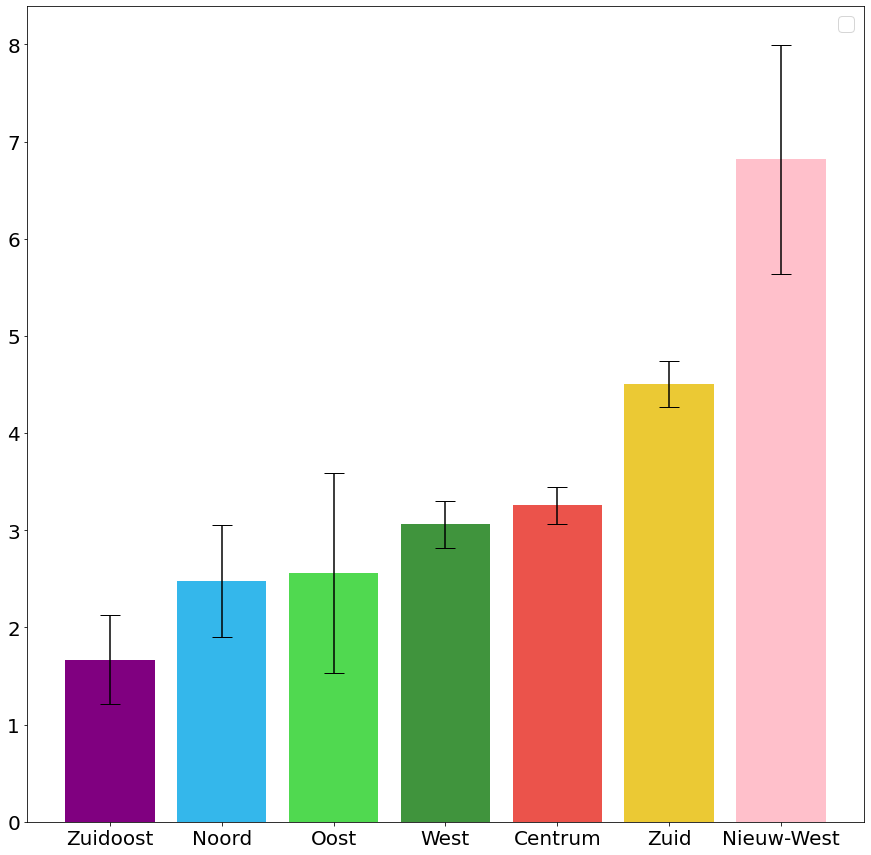

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict:
    avg_crimes_per_distr_dict_cd, confidence_bounds = get_average_crime_per_distr(output_dict[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_cd.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal disconnectivity {keys}")
    print(ks_test(avg_crimes_per_distr_dict_cd))
    plot_district_means_bar(avg_crimes_per_distr_dict_cd, district_colors,confidence_bounds,f"criminaldisconnectivity_{keys}_")

## Criminal risk aversion

In [36]:
num_runs = 50
output_dict_ra = {}

criminal_risk_aversions = [0, 10, 100, 500]

for val in criminal_risk_aversions:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_aversion=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_ra:
            output_dict_ra[val].append(output)
        else:
            output_dict_ra[val] = [output]
        #outputs.append(output)

Run 50/50 of value 0


In [52]:
with open('experiment_outputs/experiment_output_ra.pkl', 'wb') as f:
    pickle.dump(output_dict_ra, f)

Criminal risk aversion 0
KstestResult(statistic=0.5484285714285714, pvalue=0.017202573586448278)


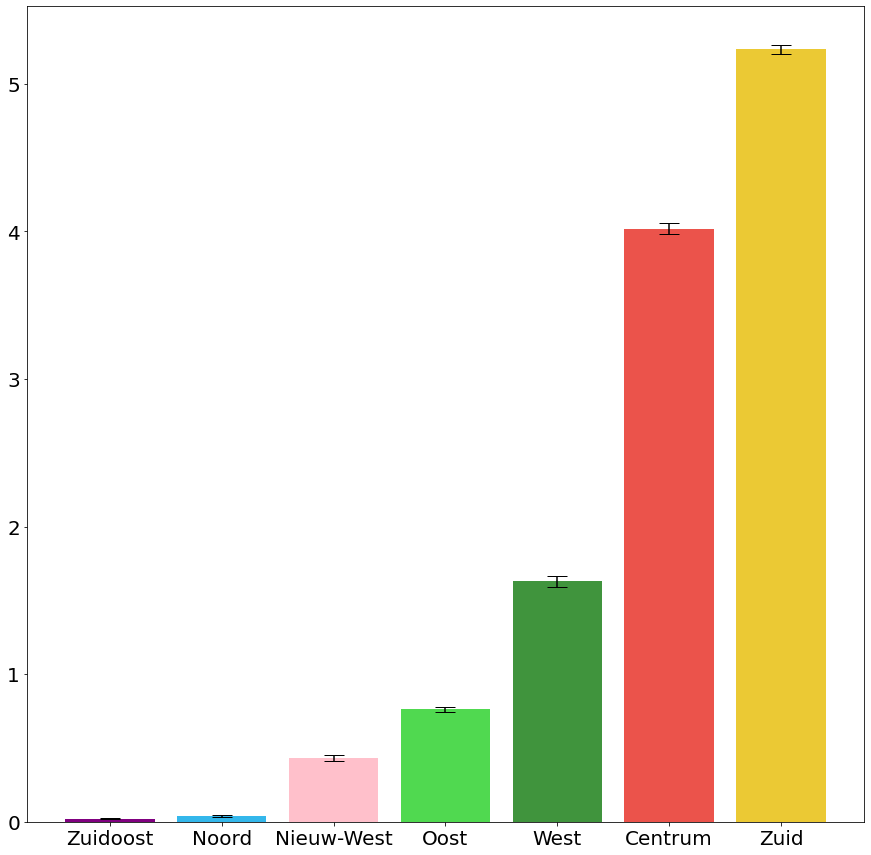

In [41]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_ra:
    avg_crimes_per_distr_dict_ra, confidence_bounds_ra = get_average_crime_per_distr(output_dict_ra[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_ra.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal risk aversion {keys}")
    print(ks_test(avg_crimes_per_distr_dict_ra))
    plot_district_means_bar(avg_crimes_per_distr_dict_ra, district_colors,confidence_bounds_ra, f"riskaversion_{keys}_")


In [ ]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

4.497512437810945 1.0945273631840795


## Jail sentence

In [ ]:
num_runs = 50
output_dict_jt = {}

jail_sentences = [0, 5, 10, 20]

for val in jail_sentences:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(jail_sentence=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_jt:
            output_dict_jt[val].append(output)
        else:
            output_dict_jt[val] = [output]
        #outputs.append(output)

Run 3 of value 100


In [ ]:
with open('experiment_outputs/experiment_output_jt.pkl', 'wb') as f:
    pickle.dump(output_dict_jt, f)

No handles with labels found to put in legend.


Criminal risk aversion 0


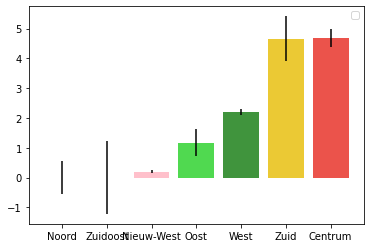

Criminal risk aversion 10


No handles with labels found to put in legend.


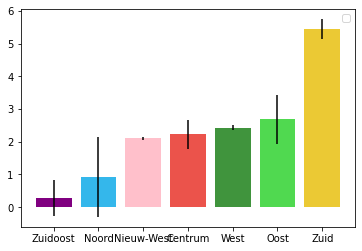

No handles with labels found to put in legend.


Criminal risk aversion 100


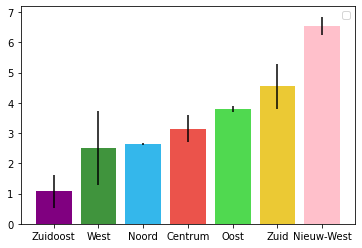

No handles with labels found to put in legend.


Criminal risk aversion 500


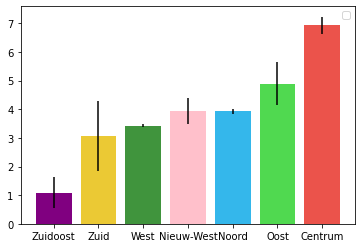

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_jt:
    avg_crimes_per_distr_dict_jt, confidence_bounds_jt = get_average_crime_per_distr(output_dict_jt[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_jt.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Jail sentence {keys}")
    print(ks_test(avg_crimes_per_distr_dict_jt))
    plot_district_means_bar(avg_crimes_per_distr_dict_jt, district_colors,confidence_bounds_jt, f"jailsentence_{keys}_")

## Criminal Risk Radius

In [19]:
num_runs = 50
output_dict_crr = {}

criminal_risk_radiuses = [1, 2]

for val in criminal_risk_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_radius=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_rwadius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_crr:
            output_dict_crr[val].append(output)
        else:
            output_dict_crr[val] = [output]
        #outputs.append(output)

Run 50/50 of value 2


In [ ]:
with open('experiment_outputs/experiment_output_crr.pkl', 'wb') as f:
    pickle.dump(output_dict_crr, f)

Criminal Risk Radius 1


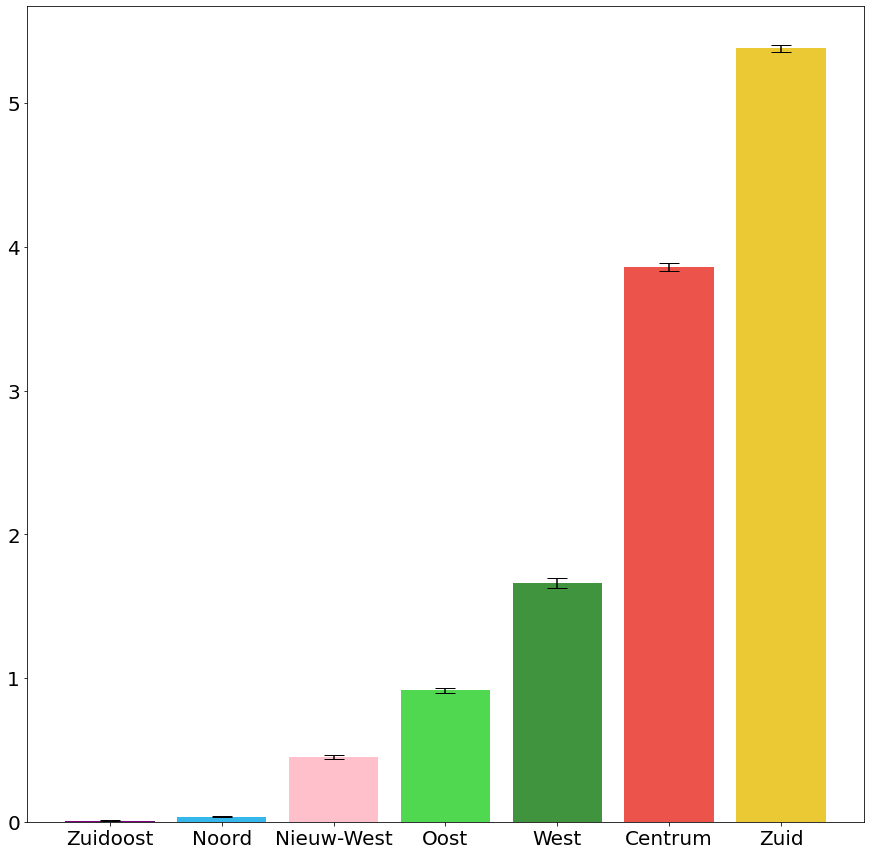

Criminal Risk Radius 2


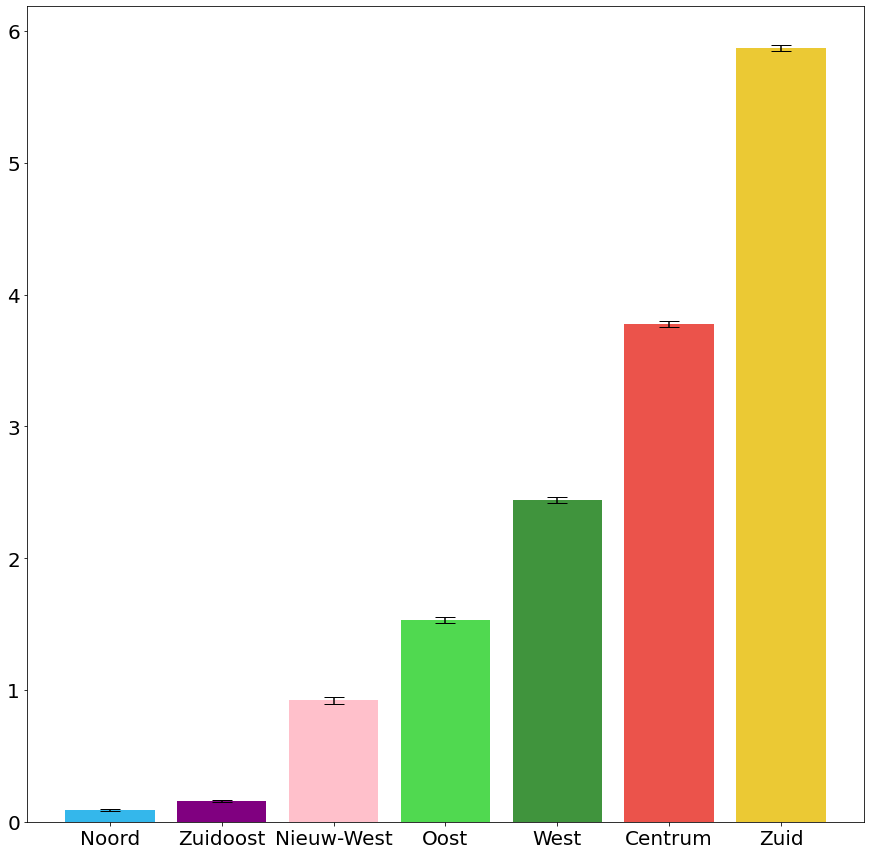

In [22]:

district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_crr:
    avg_crimes_per_distr_dict_crr, confidence_bounds_crr = get_average_crime_per_distr(output_dict_crr[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_crr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal Risk Radius {keys}")
    print(ks_test(avg_crimes_per_distr_dict_crr))
    plot_district_means_bar(avg_crimes_per_distr_dict_crr, district_colors,confidence_bounds_crr, f"criminalriskradius_{keys}_")


## Baseline run

In [15]:
num_runs = 50
output_dict_baseline = {}
val = 0

for run in range(num_runs):
    clear_output()
    print(f"Run {run+1}/{num_runs}")
    m = SugarscapeCg()
    #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
    output = run_model(m)
    if val in output_dict_baseline:
        output_dict_baseline[val].append(output)
    else:
        output_dict_baseline[val] = [output]
    #outputs.append(output)

Run 50/50


In [ ]:
with open('experiment_outputs/experiment_output_baseline.pkl', 'wb') as f:
    pickle.dump(output_dict_baseline, f)

Baseline 0


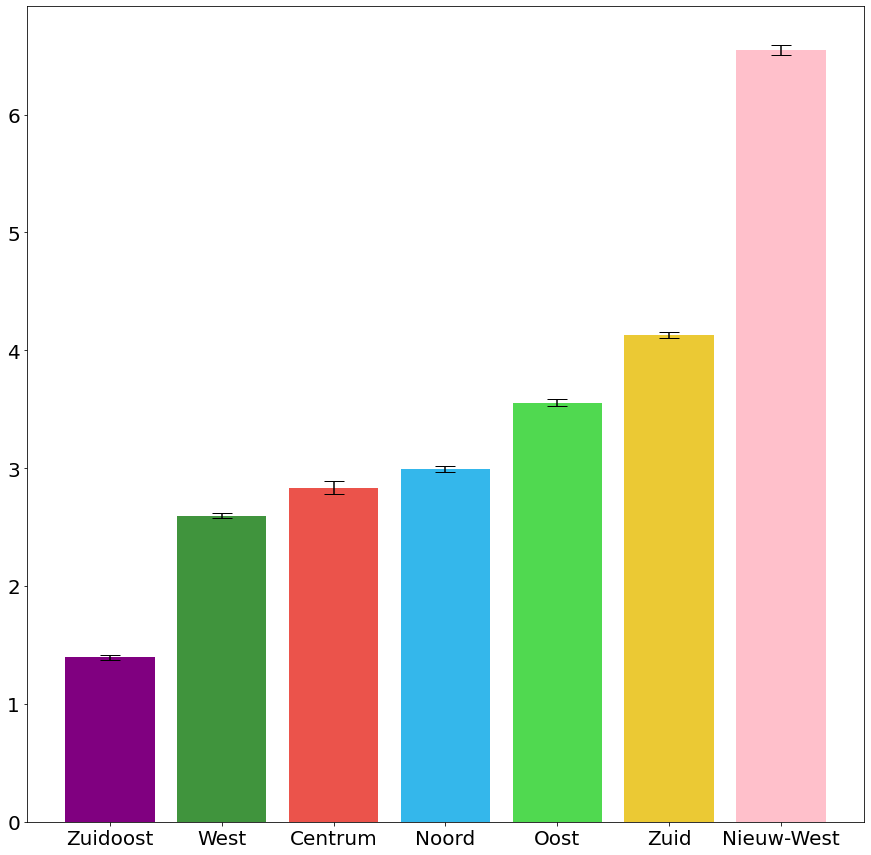

In [16]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_baseline:
    avg_crimes_per_distr_dict_baseline, confidence_bounds_baseline = get_average_crime_per_distr(output_dict_baseline[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_baseline.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Baseline {keys}")
    print(ks_test(avg_crimes_per_distr_dict_baseline))
    plot_district_means_bar(avg_crimes_per_distr_dict_baseline, district_colors,confidence_bounds_baseline, f"baseline_{keys}_")

## Cop Catch Radius

In [12]:
num_runs = 50
output_dict_cocr = {}

cop_catch_radiuses = [1, 2, 5, 10]

for val in cop_catch_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(cop_catch_radius=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_cocr:
            output_dict_cocr[val].append(output)
        else:
            output_dict_cocr[val] = [output]
        #outputs.append(output)

Run 2/50 of value 1


In [ ]:
with open('experiment_outputs/experiment_output_cocr.pkl', 'wb') as f:
    pickle.dump(output_dict_cocr, f)

No handles with labels found to put in legend.


Criminal risk aversion 0


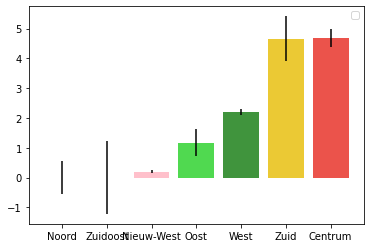

Criminal risk aversion 10


No handles with labels found to put in legend.


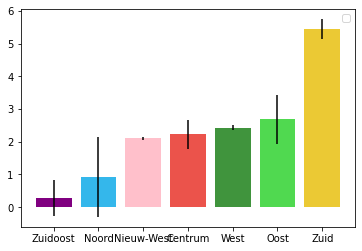

No handles with labels found to put in legend.


Criminal risk aversion 100


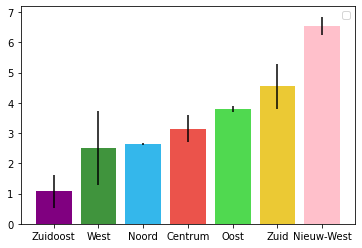

No handles with labels found to put in legend.


Criminal risk aversion 500


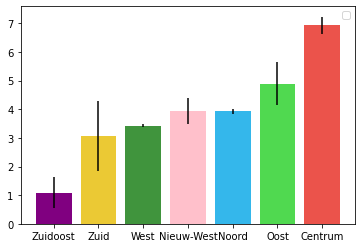

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_cocr:
    avg_crimes_per_distr_dict_cocr, confidence_bounds_cocr = get_average_crime_per_distr(output_dict_cocr[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_cocr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Cop Catch Radius {keys}")
    print(ks_test(avg_crimes_per_distr_dict_cocr))
    plot_district_means_bar(avg_crimes_per_distr_dict_cocr, district_colors,confidence_bounds_cocr, f"copcatchradius_{keys}_")